In [ ]:
!pip install tensorflow-gpu==1.15
!pip install keras==2.2.4

     |████████████████████████████████| 411.5MB 18kB/s 
     |████████████████████████████████| 512kB 46.6MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 3.8MB 46.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d9e0a638e6bc68e5e46e1a22dab8b2996c41c649fd4f374a3a8c413777fea3af
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Loading the Capsule Network libraries

In [ ]:
!cp /content/drive/My\ Drive/DeepCaps/capslayers.py /content/
!cp /content/drive/My\ Drive/DeepCaps/LoadCapsuleNetworkModel.py /content/

In [ ]:
#importing libraries
import zipfile
import os
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from LoadCapsuleNetworkModel import Capsnet
from sklearn.metrics import matthews_corrcoef,confusion_matrix,classification_report
import itertools

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
BASE_PATH = '/content'

def extract_dataset(path):
  #Extracting the dataset from the zip file

  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(BASE_PATH)
  zip_ref.close()

In [ ]:
#Extracting the Dataset
extract_dataset('/content/drive/My Drive/Research_Dataset/Dataset.zip')

In [ ]:
#Loading the train, test and validation sets
train = pd.read_csv('/content/Dataset/train.csv')
test = pd.read_csv('/content/Dataset/test.csv')
val = pd.read_csv('/content/Dataset/val.csv')

In [ ]:
#Loading the model for training and evaluation
model, eval_model = Capsnet(input_shape=[128,128,3], n_class=3, routings=3)

In [ ]:
#Model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 128 512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
convert_to_caps_1 (ConvertToCap (None, 128, 128, 128 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_cap

In [ ]:
train.head()

,Image,CancerType,lung_aca,lung_n,lung_scc
0,lungscc269.jpeg,lung_scc,0,0,1
1,lungn2022.jpeg,lung_n,0,1,0
2,lungn3863.jpeg,lung_n,0,1,0
3,lungaca1735.jpeg,lung_aca,1,0,0
4,lungaca4617.jpeg,lung_aca,1,0,0


In [ ]:
def transform_data(df,dir):
  '''
  Function that transforms the images for 
  test train and validation into numpy arrays along woth their label encodings
  '''
  temp_X = []
  temp_y = []
  path = '/content/Dataset/'+dir
  for index, row in df.iterrows():
    #image
    img = cv2.cvtColor(cv2.imread(path+'/'+row['Image']),cv2.COLOR_BGR2RGB)
    resize = cv2.resize(img,(128,128),interpolation = cv2.INTER_CUBIC)
    temp_X.append(resize)
    #labels
    temp_y.append(np.array([row['lung_aca'],row['lung_n'],row['lung_scc']]).astype('float32'))
  
  X = np.stack(temp_X)
  y = np.stack(temp_y)

  X = X.astype('float32')/255.

  return X,y


In [ ]:
X_train,y_train = transform_data(train,'Train')
X_test,y_test = transform_data(test,'Test')
X_val,y_val = transform_data(val,'Val')

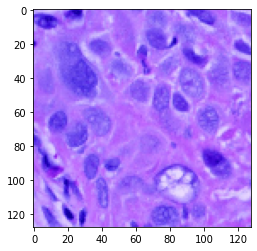

In [ ]:
plt.imshow(X_train[0])

In [ ]:
y_train[0]

array([0., 0., 1.], dtype=float32)

In [ ]:
#Marginal Loss Function of capsule Network
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.90 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
    return K.mean(K.sum(L, 1))

In [ ]:
def train(model, data):
    
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('CapsuleNetwork.csv')
    checkpoint = callbacks.ModelCheckpoint('save_weights_ep_no_{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.0001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=0.0001), loss=[margin_loss, 'mse'], metrics={'capsnet': "accuracy"})
    

    #Training with data augmentation
    def train_generator(x, y, batch_size):
        train_datagen = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=90,
                                zoom_range=[0.3,0.6])  
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])
    
    #Generator of loading images and labels in batches
    model.fit_generator(generator=train_generator(x_train, y_train, 32),
                        steps_per_epoch=int(y_train.shape[0] / 32),
                        epochs=30,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay])
    
    #Saving the trained model
    model.save_weights('/content/drive/My Drive/Research_Dataset/DeepCaps/trained_model_CapsuleNetwork.h5')
    print('Trained model saved to \'trained_model_CapsuleNetwork.h5\'')

    return model

In [ ]:
train(model=model, data=((X_train, y_train), (X_val, y_val))) 


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
299/299 [==============================] - 303s 1s/step - loss: 0.3456 - capsnet_loss: 0.3185 - decoder_loss: 0.0677 - capsnet_acc: 0.6491 - val_loss: 0.4095 - val_capsnet_loss: 0.3984 - val_decoder_loss: 0.0277 - val_capsnet_acc: 0.3937

Epoch 00001: val_loss improved from inf to 0.40953, saving model to weights-01.h5
Epoch 2/30
299/299 [==============================] - 297s 992ms/step - loss: 0.1284 - capsnet_loss: 0.1190 - decoder_loss: 0.0236 - capsnet_acc: 0.8553 - val_loss: 0.2589 - val_capsnet_loss: 0.2489 - val_decoder_loss: 0.0251 - val_capsnet_acc: 0.6629

Epoch 00002: val_loss improved from 0.40953 to 0.25888, saving model to weights-02.h5
Epoch 3/30
299/299 [==============================] - 293s 981ms/step - loss: 0.0745 - capsnet_loss: 0.0652 - decoder_loss: 0.0233 - capsnet_acc: 0.9271 - val_loss: 0.2119 - val_capsnet_loss: 0.2021 - val_decoder_loss: 0.0245 - val_

In [ ]:
def test_model(eval_model, data):
    (x_test, y_test) = data
    eval_model.load_weights("/content/drive/My Drive/DeepCaps/trained_model_DeepCaps.h5")#CapsuleNetwork
    y_pred, _ = eval_model.predict(x_test)
    p1 = np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0]
    print('Test acc:', p1)
    return y_pred

In [ ]:
y_hat = test_model(eval_model, (X_test, y_test))

Test acc: 0.9986666666666667


In [ ]:
y_hat

array([[0.9575371 , 0.04293359, 0.0467374 ],
       [0.93195224, 0.03612895, 0.03262172],
       [0.02325376, 0.03768128, 0.91777146],
       ...,
       [0.9343453 , 0.02627522, 0.03816189],
       [0.94917166, 0.07092631, 0.01550283],
       [0.01805777, 0.03318052, 0.9109543 ]], dtype=float32)

In [ ]:
label_encodings = test.drop_duplicates(['CancerType','lung_aca','lung_n','lung_scc'])[['CancerType','lung_aca','lung_n','lung_scc']]
label_encodings=label_encodings.reset_index(drop=True)

In [ ]:
label_encodings

,CancerType,lung_aca,lung_n,lung_scc
0,lung_aca,1,0,0
1,lung_scc,0,0,1
2,lung_n,0,1,0


In [ ]:
'''
Function for Reversing the encodings to string labels
This function converts the binary encodings to actual string labels.
The string labels will be used for estimating the MCC and determining the 
confusion matrix
'''
def r_encodings(vectr):
  ecdr =[]
  for item in np.argmax(vectr, 1):
    if item == 0:
      ecdr.append('lung_aca') 
    elif item == 1:
      ecdr.append('lung_n') 
    else:
      ecdr.append('lung_scc')
  return ecdr

y_pred = r_encodings(y_hat)
y_actual = r_encodings(y_test)

In [ ]:
print(y_pred)
print(y_actual)

['lung_aca', 'lung_aca', 'lung_scc', 'lung_n', 'lung_n', 'lung_n', 'lung_n', 'lung_scc', 'lung_n', 'lung_n', 'lung_scc', 'lung_n', 'lung_n', 'lung_aca', 'lung_n', 'lung_aca', 'lung_n', 'lung_scc', 'lung_aca', 'lung_n', 'lung_n', 'lung_aca', 'lung_scc', 'lung_n', 'lung_scc', 'lung_aca', 'lung_scc', 'lung_aca', 'lung_scc', 'lung_n', 'lung_aca', 'lung_aca', 'lung_scc', 'lung_n', 'lung_scc', 'lung_aca', 'lung_n', 'lung_aca', 'lung_aca', 'lung_n', 'lung_scc', 'lung_n', 'lung_aca', 'lung_scc', 'lung_n', 'lung_scc', 'lung_scc', 'lung_aca', 'lung_n', 'lung_n', 'lung_n', 'lung_aca', 'lung_n', 'lung_aca', 'lung_scc', 'lung_scc', 'lung_n', 'lung_aca', 'lung_scc', 'lung_aca', 'lung_n', 'lung_aca', 'lung_scc', 'lung_n', 'lung_n', 'lung_n', 'lung_aca', 'lung_n', 'lung_aca', 'lung_scc', 'lung_scc', 'lung_aca', 'lung_n', 'lung_n', 'lung_scc', 'lung_aca', 'lung_n', 'lung_n', 'lung_aca', 'lung_aca', 'lung_aca', 'lung_n', 'lung_aca', 'lung_aca', 'lung_n', 'lung_n', 'lung_n', 'lung_scc', 'lung_aca', 'lung

In [ ]:
#Estimating the Matthew's correlation matrix
mcc = matthews_corrcoef(y_actual, y_pred)
print("Matthews Correlation Coefficient: ", mcc)

Matthews Correlation Coefficient:  0.9980009334422903


In [ ]:
list(label_encodings['CancerType'])

['lung_aca', 'lung_scc', 'lung_n']

In [ ]:

print(classification_report(y_actual, y_pred, target_names=list(label_encodings['CancerType'])))

              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       980
    lung_scc       1.00      1.00      1.00      1017
      lung_n       1.00      1.00      1.00      1003

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
confusion_mtx = confusion_matrix(y_true = y_actual,y_pred = y_pred,labels=list(label_encodings['CancerType']))
confusion_mtx.T

array([[ 979,    0,    0],
       [   0, 1003,    3],
       [   1,    0, 1014]])

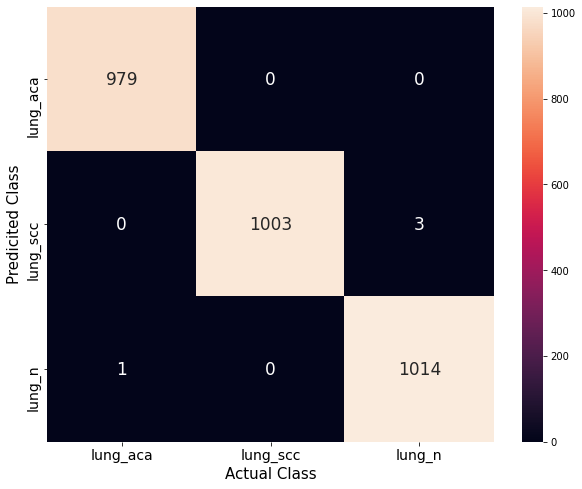

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(confusion_mtx.T, annot=True, ax = ax,fmt='g',annot_kws={"size": 17})
ax.xaxis.set_ticklabels(list(label_encodings['CancerType']))
ax.yaxis.set_ticklabels(list(label_encodings['CancerType']))
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.set_xlabel('Actual Class')
ax.set_ylabel('Predicited Class')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
history = pd.read_csv('/content/drive/My Drive/CapsuleNetwork/CapsuleNetwork.csv')

In [ ]:
history

,epoch,capsnet_acc,capsnet_loss,decoder_loss,loss,val_capsnet_acc,val_capsnet_loss,val_decoder_loss,val_loss
0,0,0.649143,0.318501,0.067748,0.345600,0.393750,0.398449,0.027707,0.409532
1,1,0.855321,0.118979,0.023585,0.128413,0.662917,0.248854,0.025067,0.258881
2,2,0.927138,0.065178,0.023262,0.074483,0.755417,0.202076,0.024487,0.211870
3,3,0.965607,0.033704,0.022997,0.042903,0.757917,0.185224,0.024465,0.195010
4,4,0.977211,0.021653,0.022557,0.030676,0.907917,0.066348,0.023585,0.075782
5,5,0.986515,0.011550,0.022335,0.020484,0.982917,0.013188,0.023945,0.022766
6,6,0.989651,0.009800,0.022243,0.018697,0.805833,0.152021,0.023831,0.161553
7,7,0.988292,0.010923,0.021996,0.019721,0.961250,0.028089,0.022812,0.037214
8,8,0.994460,0.005444,0.021760,0.014148,0.996667,0.002608,0.022659,0.011671
9,9,0.992891,0.005712,0.021710,0.014396,0.966250,0.024422,0.022916,0.033589


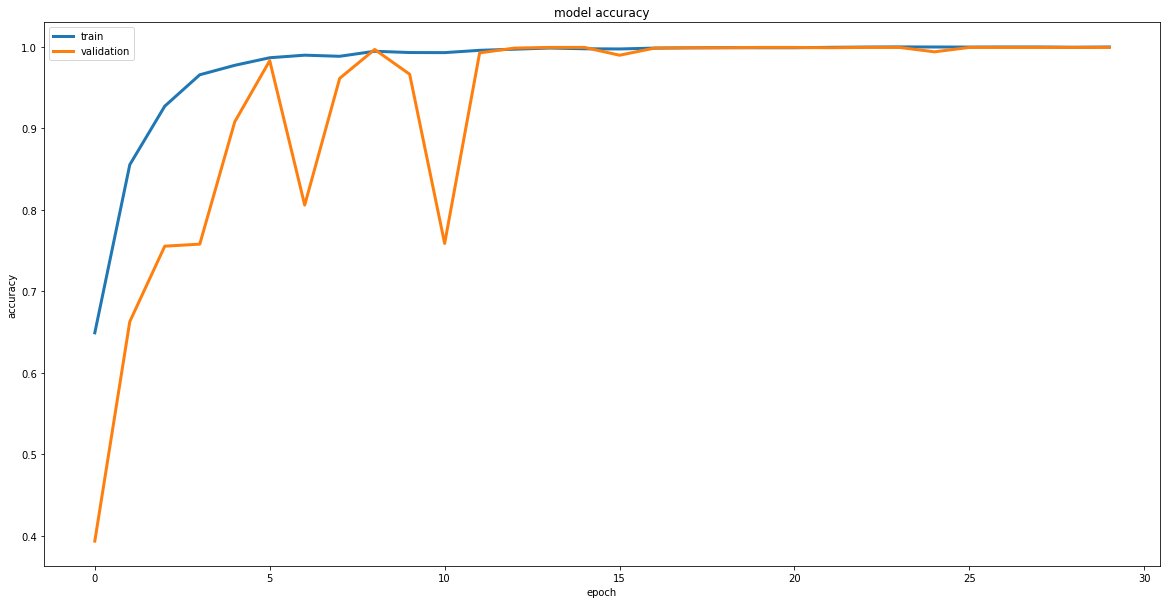

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history['capsnet_acc'],linewidth=3.0)
plt.plot(history['val_capsnet_acc'],linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

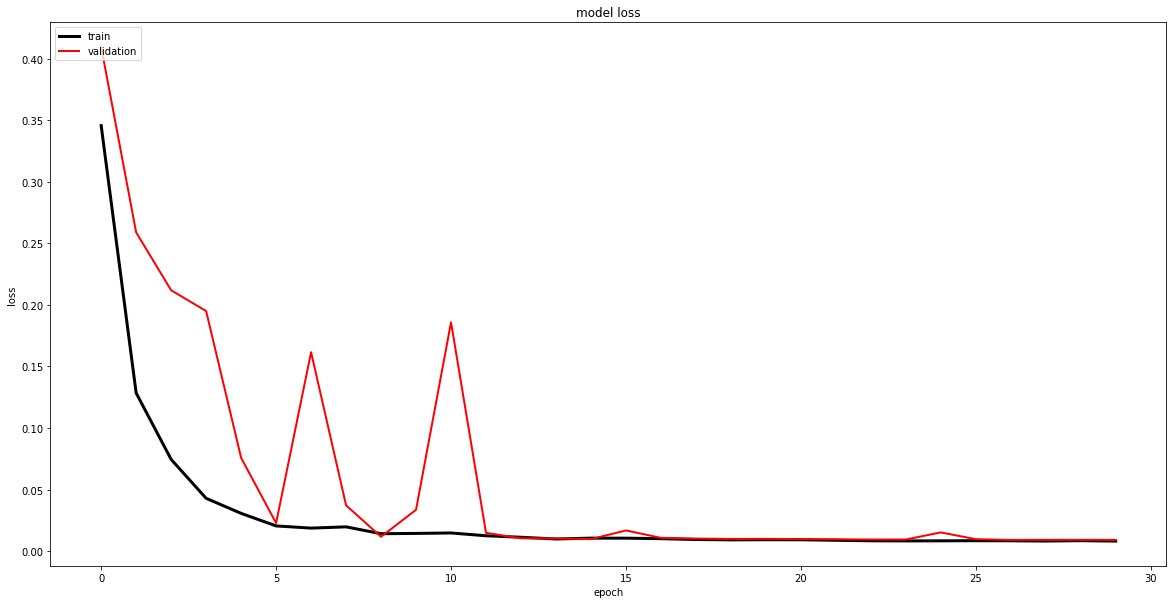

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history['loss'], color='black',linewidth=3.0)
plt.plot(history['val_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()